In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.datasets import mnist
from keras.models import Model
import cv2

In [2]:
# nl = [0, 1, 2, 3, 4, 5, 6, 7, 9]
abn = 8
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
normal_data = x_train[y_train != abn]
normal_labels = y_train[y_train != abn]
test_data = x_test
test_labels = y_test
test_labels_T_F = np.where(test_labels != abn, True, False)

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
normal_data.shape, test_data.shape, test_labels.shape

((54149, 28, 28), (10000, 28, 28), (10000,))

In [4]:
normal_labels[0:20], test_labels[0:20]

(array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 6, 9, 4],
       dtype=uint8),
 array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4],
       dtype=uint8))

In [5]:
# normal_data = normal_data.astype('float32') / 255.
# test_data = test_data.astype('float32') / 255.

In [6]:
normal_test_data = test_data[test_labels != abn]
abnormal_test_data = test_data[test_labels == abn]

In [7]:
normal_test_data.shape, abnormal_test_data.shape

((9026, 28, 28), (974, 28, 28))

In [8]:
normal_test_labels = test_labels[test_labels != abn]
abnormal_test_labels = test_labels[test_labels == abn]
normal_test_labels[0:20], abnormal_test_labels[0:20]

(array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4],
       dtype=uint8),
 array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
       dtype=uint8))

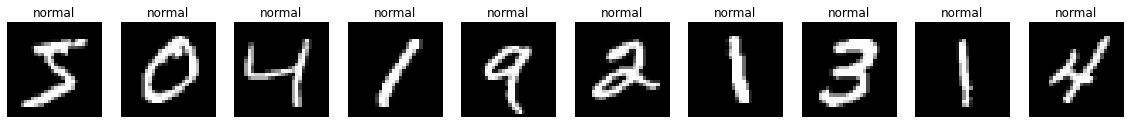

In [9]:
# First 10 normal digits

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("normal")
    plt.imshow(normal_data[i])
    plt.axis('off')
    plt.gray()
plt.show()

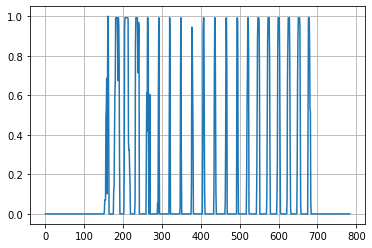

In [10]:
# 1 dim plot of (flattened array of) first normal digit
plt.grid()
plt.plot(np.arange(28*28), normal_data[0].ravel())
plt.show()

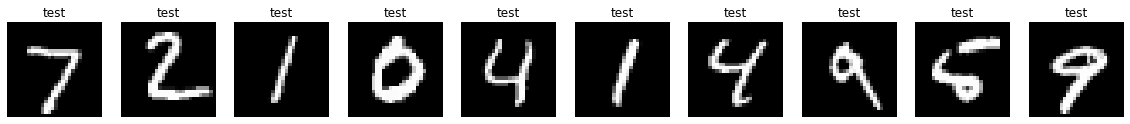

In [11]:
# First 10 test digits

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("test")
    plt.imshow(test_data[i])
    plt.axis('off')
    plt.gray()
plt.show()

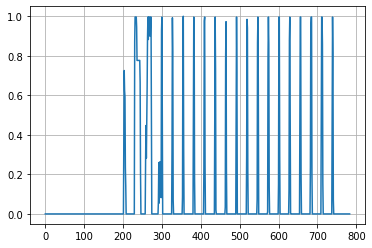

In [12]:
# 1 dim plot of first test digit
plt.grid()
plt.plot(np.arange(28*28), test_data[0].ravel())
plt.show()

In [13]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(128, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(28*28, activation="sigmoid"),
      layers.Reshape((28, 28))])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [14]:
autoencoder.compile(optimizer='adam', loss='mae')

In [15]:
history = autoencoder.fit(normal_data, normal_data, 
          epochs=50, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/50
106/106 [==============================] - 8s 17ms/step - loss: 0.1686 - val_loss: 0.1249
Epoch 2/50
106/106 [==============================] - 1s 9ms/step - loss: 0.1177 - val_loss: 0.1174
Epoch 3/50
106/106 [==============================] - 1s 7ms/step - loss: 0.1122 - val_loss: 0.1125
Epoch 4/50
106/106 [==============================] - 1s 7ms/step - loss: 0.1079 - val_loss: 0.1095
Epoch 5/50
106/106 [==============================] - 1s 8ms/step - loss: 0.1052 - val_loss: 0.1064
Epoch 6/50
106/106 [==============================] - 1s 8ms/step - loss: 0.1025 - val_loss: 0.1040
Epoch 7/50
106/106 [==============================] - 1s 8ms/step - loss: 0.0996 - val_loss: 0.1002
Epoch 8/50
106/106 [==============================] - 1s 8ms/step - loss: 0.0961 - val_loss: 0.0969
Epoch 9/50
106/106 [==============================] - 1s 8ms/step - loss: 0.0933 - val_loss: 0.0949
Epoch 10/50
106/106 [==============================] - 1s 7ms/step - loss: 0.0914 - val_loss: 0.093

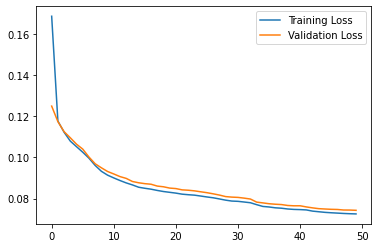

In [16]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

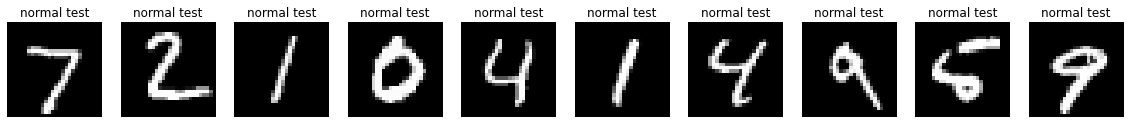

In [17]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

# First 10 normal test digits

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("normal test")
    plt.imshow(normal_test_data[i])
    plt.axis('off')
    plt.gray()
plt.show()

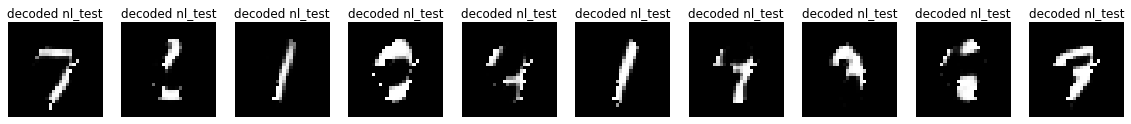

In [18]:
# First 10 decoded normal test digits

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("decoded nl_test")
    plt.imshow(decoded_data[i])
    plt.axis('off')
    plt.gray()
plt.show()

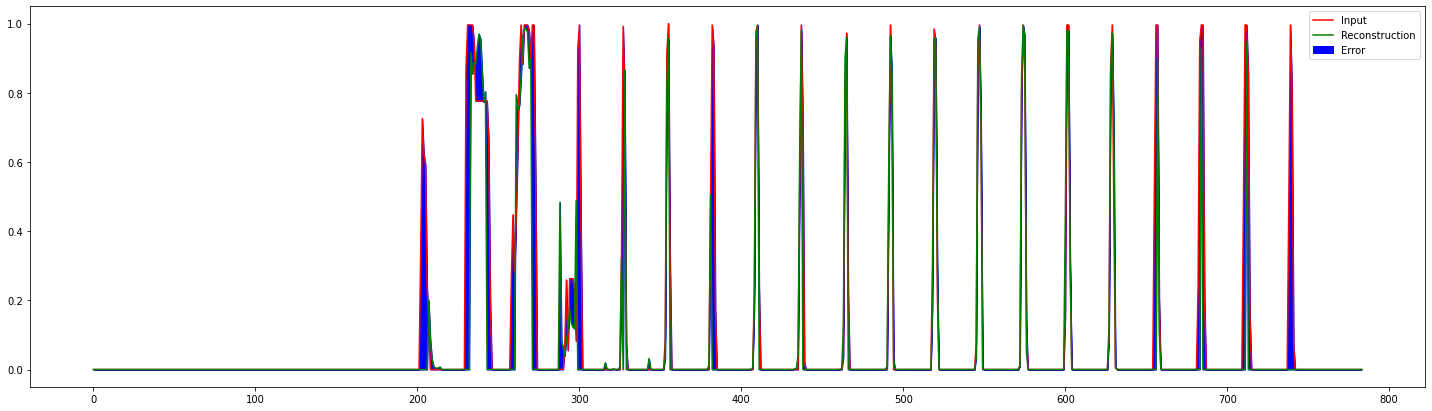

In [19]:
plt.figure(figsize=(25,7))
plt.plot(normal_test_data[0].ravel(), 'r')
plt.plot(decoded_data[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), decoded_data[0].ravel(), normal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

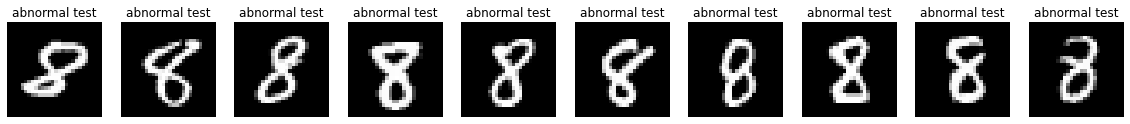

In [20]:
encoded_abn_data = autoencoder.encoder(abnormal_test_data).numpy()
decoded_abn_data = autoencoder.decoder(encoded_abn_data).numpy()

# First 10 abnormal test digits

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("abnormal test")
    plt.imshow(abnormal_test_data[i])
    plt.axis('off')
    plt.gray()
plt.show()

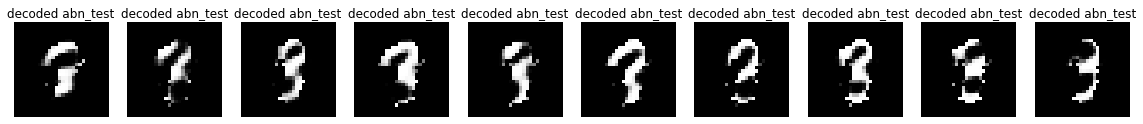

In [21]:
# First 10 decoded abnormal test digits

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("decoded abn_test")
    plt.imshow(decoded_abn_data[i])
    plt.axis('off')
    plt.gray()
plt.show()

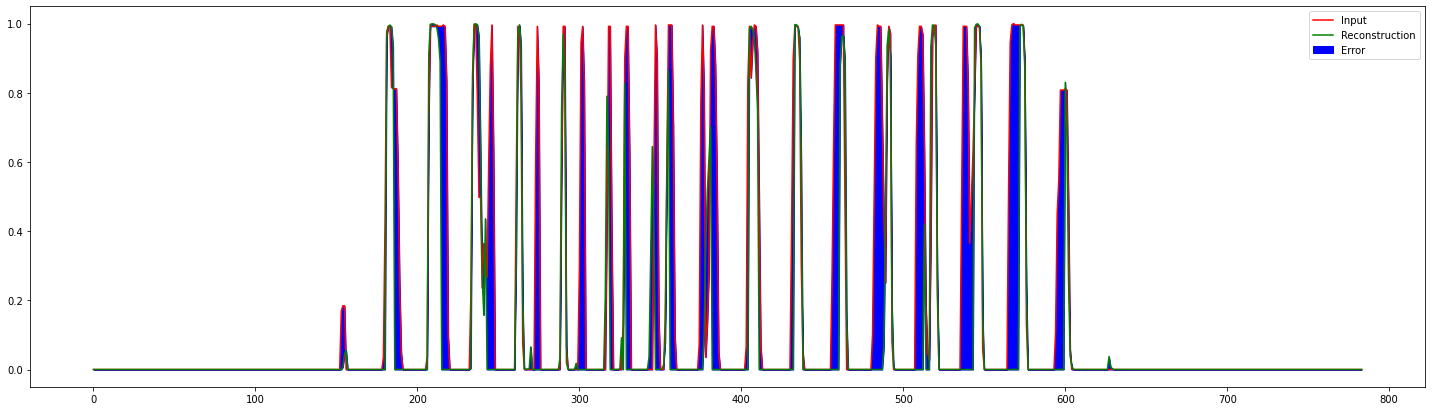

In [22]:
plt.figure(figsize=(25,7))
plt.plot(abnormal_test_data[0].ravel(), 'r')
plt.plot(decoded_abn_data[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), decoded_abn_data[0].ravel(), abnormal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

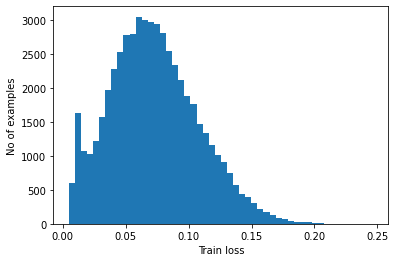

In [23]:
reconstructions = autoencoder.predict(normal_data)
train_loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), normal_data.reshape(-1, 784))
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [24]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.10731875


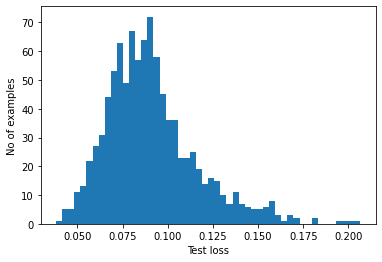

In [25]:
reconstructions = autoencoder.predict(abnormal_test_data)
abn_test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), abnormal_test_data.reshape(-1,784))

plt.hist(abn_test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [26]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), data.reshape(-1, 784))
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  cf = confusion_matrix(labels, predictions)
  print("Confusion Matrix: \n prediction: F      T ")
  print("             {}   {}".format(preds[preds == False].shape[0], preds[preds == True].shape[0]))
  print(" label: F   [[{}   {}]    {}".format(cf[0,0], cf[0,1], test_labels_T_F[test_labels_T_F == False].shape[0]))
  print("        T    [{}   {}]]   {}".format(cf[1,0], cf[1,1], test_labels_T_F[test_labels_T_F == True].shape[0]))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [27]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels_T_F)

Confusion Matrix: 
 prediction: F      T 
             1672   8328
 label: F   [[205   769]    974
        T    [1467   7559]]   9026
Accuracy = 0.7764
Precision = 0.9076609029779059
Recall = 0.8374695324617771


In [28]:
print(confusion_matrix(test_labels_T_F, preds))

[[ 205  769]
 [1467 7559]]


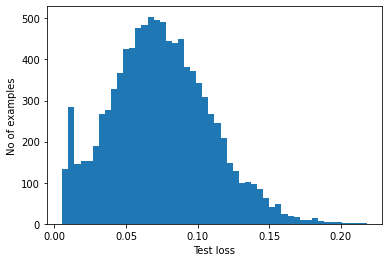

In [29]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), test_data.reshape(-1,784))

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()